### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETMultiViewDataset, process_labels
from src.model import FoundationalCVModel, MultiViewFoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test
import random

In [2]:
def set_random_seeds(seed):
    random.seed(seed)          # Python random module
    np.random.seed(seed)       # NumPy random module
    torch.manual_seed(seed)    # PyTorch CPU random generator
    torch.cuda.manual_seed(seed)  # PyTorch GPU random generator (if using CUDA)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on CUDA
    torch.backends.cudnn.benchmark = False    # Avoid non-deterministic algorithms

In [3]:
set_random_seeds(42)
# Constants:
DATASET = 'C:\\Users\\preet\\Documents\\mBRSET\\mbrset-a-mobile-brazilian-retinal-dataset-1.0\\'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images')
LABEL = 'final_icdr'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'multi_labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
"""
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]


#NORM_MEAN = None # [0.485, 0.456, 0.406]
#NORM_STD = None # [0.229, 0.224, 0.225]
BACKBONE = 'resnet50'
#BACKBONE = 'dinov2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128, 128]
num_classes = 2

BATCH_SIZE = 64 #16
NUM_WORKERS = 8 #4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

USE_RELU = True #addition of RELU for final model classification, between the two linear layers after the backbone
# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [4]:
df = pd.read_csv(LABELS_PATH)
df.head()

,Unnamed: 0,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,...,file1,laterality,final_artifacts,final_quality,final_icdr,final_edema,normality,file2,file3,file4
0,0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,...,1.1.jpg,right,yes,yes,4.0,no,abnormal,1.2.jpg,1.3.jpg,1.4.jpg
1,4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,...,10.1.jpg,right,yes,yes,0.0,no,abnormal,10.2.jpg,10.3.jpg,10.4.jpg
2,8,100,66,1,1.0,0.0,NaN,1.0,0.0,0.0,...,100.1.jpg,right,yes,yes,0.0,no,abnormal,100.2.jpg,100.3.jpg,100.4.jpg
3,12,1000,50,0,2.0,0.0,NaN,1.0,0.0,0.0,...,1000.1.jpg,right,yes,yes,0.0,no,abnormal,1000.2.jpg,1000.3.jpg,1000.4.jpg
4,16,1001,36,0,2.0,0.0,NaN,1.0,0.0,0.0,...,1001.1.jpg,right,yes,yes,0.0,no,abnormal,1001.2.jpg,1001.3.jpg,1001.4.jpg


(1291, 29)
Unnamed: 0                        0
patient                           0
age                               0
sex                               0
dm_time                          14
insulin                          12
insulin_time                   1037
oraltreatment_dm                 11
systemic_hypertension            11
insurance                        12
educational_level                13
alcohol_consumption              19
smoking                          22
obesity                          19
vascular_disease                 19
acute_myocardial_infarction      21
nephropathy                      20
neuropathy                       19
diabetic_foot                    27
file1                             0
laterality                        0
final_artifacts                   0
final_quality                     0
final_icdr                        0
final_edema                      73
normality                         0
file2                             0
file3            

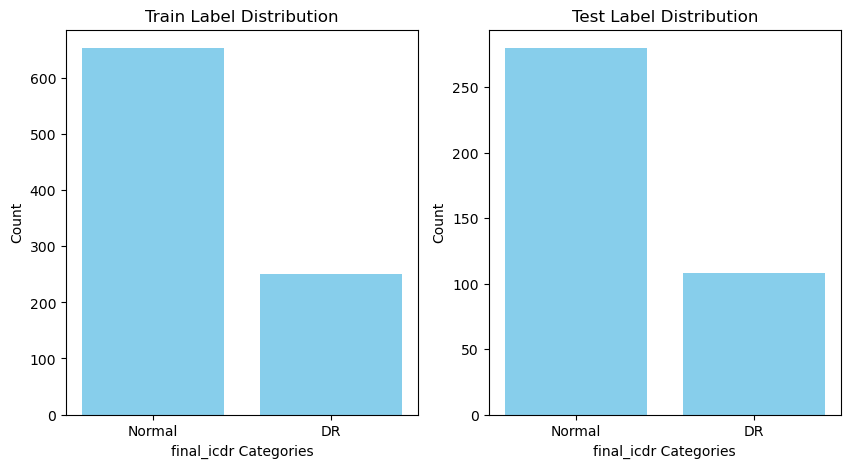

Getting validation set...
Train data shape: (310, 29)
Test data shape: (78, 29)


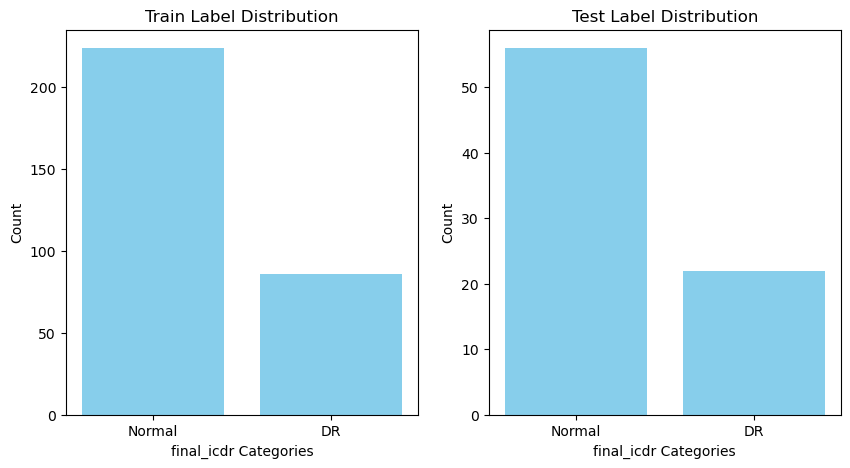

In [5]:
# Split dataset into train, test and validation:
# Count NaNs in each column
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0.0 else ('DR'))

nan_counts = df.isna().sum()
print(df.shape)
print(nan_counts)
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False,random_state=42)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20,random_state=42)



In [6]:

# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(90),  # Randomly rotate the image by up to 10 degrees
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.4, contrast=0.1, saturation=0.0, hue=0.0),

])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [7]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
print(df_train.head())
print(LABEL)
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)


      Unnamed: 0  patient age  sex  dm_time  insulin  insulin_time   
379         1516      154  71    0     10.0      0.0           NaN  \
37           148     1032  64    0      3.0      0.0           NaN   
64           256      106  74    1     24.0      1.0          15.0   
1038        4152      765  73    0      2.0      0.0           NaN   
998         3992      728  72    1      1.0      0.0           NaN   

      oraltreatment_dm  systemic_hypertension  insurance  ...       file1   
379                1.0                    1.0        0.0  ...   154.1.jpg  \
37                 1.0                    0.0        0.0  ...  1032.1.jpg   
64                 0.0                    1.0        0.0  ...   106.1.jpg   
1038               1.0                    1.0        0.0  ...   765.1.jpg   
998                1.0                    0.0        1.0  ...   728.1.jpg   

      laterality  final_artifacts  final_quality  final_icdr  final_edema   
379        right              yes      

In [8]:
# Create the custom dataset
IMG_COL_LIST=['file1','file2','file3','file4']
train_dataset = BRSETMultiViewDataset(
    df_train, 
    IMG_COL_LIST, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETMultiViewDataset(
    df_test, 
    IMG_COL_LIST, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETMultiViewDataset(
    df_val, 
    IMG_COL_LIST, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

DF col dtype object final_icdr
DF col dtype object final_icdr
DF col dtype object final_icdr


In [9]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = MultiViewFoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_views=4, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

In [10]:
# Training
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6) # Adam


In [11]:
#state_dict = torch.load('C:\\Users\\preet\\Documents\\BRSET\\BRSET\\Models\\fine_tuned_resnet50_best.pth')
#model.load_state_dict(state_dict, strict=True) 
save_dir= 'C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\Experiment4'
model = train(model, train_dataloader, val_dataloader,test_dataloader,
              criterion, optimizer, scheduler=None, num_epochs=num_epochs, save=True, save_dir = save_dir,device="cuda", 
              backbone=f'convnextv2_binary_{LABEL}',patience=7)

AMP True


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [05:18<00:00, 21.25s/it]


Epoch 1
Train loss 0.689, F1 0.531, Acc 0.625, BA 0.531
cm[[ 80 170]
 [169 484]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:33<00:00, 16.87s/it]


Epoch 1
Val loss 0.685, F1 0.240, Acc 0.295, BA 0.509
cm[[22  0]
 [55  1]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.99s/it]


cm[[ 86   0]
 [220   4]]
              precision    recall  f1-score   support

           0       0.28      1.00      0.44        86
           1       1.00      0.02      0.04       224

    accuracy                           0.29       310
   macro avg       0.64      0.51      0.24       310
weighted avg       0.80      0.29      0.15       310

F1 0.147, Acc 0.290, BA 0.509
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:36<00:00, 18.44s/it]


Epoch 2
Train loss 0.675, F1 0.608, Acc 0.631, BA 0.654
cm[[176  74]
 [259 394]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:25<00:00, 12.52s/it]


Epoch 2
Val loss 0.675, F1 0.724, Acc 0.808, BA 0.700
cm[[10 12]
 [ 3 53]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.07s/it]


cm[[ 40  46]
 [ 20 204]]
              precision    recall  f1-score   support

           0       0.67      0.47      0.55        86
           1       0.82      0.91      0.86       224

    accuracy                           0.79       310
   macro avg       0.74      0.69      0.70       310
weighted avg       0.77      0.79      0.77       310

F1 0.774, Acc 0.787, BA 0.688
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:43<00:00, 14.89s/it]


Epoch 3
Train loss 0.654, F1 0.698, Acc 0.749, BA 0.706
cm[[153  97]
 [130 523]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.00s/it]


Epoch 3
Val loss 0.657, F1 0.614, Acc 0.628, BA 0.672
cm[[17  5]
 [24 32]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.70s/it]


cm[[ 70  16]
 [ 89 135]]
              precision    recall  f1-score   support

           0       0.44      0.81      0.57        86
           1       0.89      0.60      0.72       224

    accuracy                           0.66       310
   macro avg       0.67      0.71      0.65       310
weighted avg       0.77      0.66      0.68       310

F1 0.679, Acc 0.661, BA 0.708


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:43<00:00, 14.92s/it]


Epoch 4
Train loss 0.612, F1 0.711, Acc 0.784, BA 0.699
cm[[127 123]
 [ 72 581]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.93s/it]


Epoch 4
Val loss 0.624, F1 0.712, Acc 0.744, BA 0.739
cm[[16  6]
 [14 42]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.32s/it]


cm[[ 64  22]
 [ 67 157]]
              precision    recall  f1-score   support

           0       0.49      0.74      0.59        86
           1       0.88      0.70      0.78       224

    accuracy                           0.71       310
   macro avg       0.68      0.72      0.68       310
weighted avg       0.77      0.71      0.73       310

F1 0.727, Acc 0.713, BA 0.723


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:00<00:00,  4.06s/it]


Epoch 5
Train loss 0.555, F1 0.735, Acc 0.779, BA 0.746
cm[[168  82]
 [118 535]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.46s/it]


Epoch 5
Val loss 0.596, F1 0.805, Acc 0.846, BA 0.796
cm[[15  7]
 [ 5 51]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:26<00:00, 17.30s/it]


cm[[ 56  30]
 [ 39 185]]
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        86
           1       0.86      0.83      0.84       224

    accuracy                           0.78       310
   macro avg       0.72      0.74      0.73       310
weighted avg       0.79      0.78      0.78       310

F1 0.781, Acc 0.777, BA 0.739
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:49<00:00,  7.27s/it]


Epoch 6
Train loss 0.525, F1 0.744, Acc 0.786, BA 0.755
cm[[171  79]
 [114 539]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.54s/it]


Epoch 6
Val loss 0.580, F1 0.717, Acc 0.756, BA 0.734
cm[[15  7]
 [12 44]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.06s/it]


cm[[ 65  21]
 [ 64 160]]
              precision    recall  f1-score   support

           0       0.50      0.76      0.60        86
           1       0.88      0.71      0.79       224

    accuracy                           0.73       310
   macro avg       0.69      0.74      0.70       310
weighted avg       0.78      0.73      0.74       310

F1 0.739, Acc 0.726, BA 0.735


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:27<00:00,  5.84s/it]


Epoch 7
Train loss 0.490, F1 0.777, Acc 0.828, BA 0.767
cm[[157  93]
 [ 62 591]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.56s/it]


Epoch 7
Val loss 0.577, F1 0.683, Acc 0.718, BA 0.707
cm[[15  7]
 [15 41]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.93s/it]


cm[[ 68  18]
 [ 70 154]]
              precision    recall  f1-score   support

           0       0.49      0.79      0.61        86
           1       0.90      0.69      0.78       224

    accuracy                           0.72       310
   macro avg       0.69      0.74      0.69       310
weighted avg       0.78      0.72      0.73       310

F1 0.730, Acc 0.716, BA 0.739


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:20<00:00,  9.39s/it]


Epoch 8
Train loss 0.482, F1 0.764, Acc 0.797, BA 0.786
cm[[190  60]
 [123 530]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.30s/it]


Epoch 8
Val loss 0.603, F1 0.614, Acc 0.628, BA 0.672
cm[[17  5]
 [24 32]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.28s/it]


cm[[ 74  12]
 [ 93 131]]
              precision    recall  f1-score   support

           0       0.44      0.86      0.58        86
           1       0.92      0.58      0.71       224

    accuracy                           0.66       310
   macro avg       0.68      0.72      0.65       310
weighted avg       0.78      0.66      0.68       310

F1 0.678, Acc 0.661, BA 0.723


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:40<00:00,  6.72s/it]


Epoch 9
Train loss 0.434, F1 0.771, Acc 0.819, BA 0.768
cm[[163  87]
 [ 76 577]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:31<00:00, 15.64s/it]


Epoch 9
Val loss 0.560, F1 0.747, Acc 0.795, BA 0.747
cm[[14  8]
 [ 8 48]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:11<00:00, 14.38s/it]


cm[[ 62  24]
 [ 39 185]]
              precision    recall  f1-score   support

           0       0.61      0.72      0.66        86
           1       0.89      0.83      0.85       224

    accuracy                           0.80       310
   macro avg       0.75      0.77      0.76       310
weighted avg       0.81      0.80      0.80       310

F1 0.801, Acc 0.797, BA 0.773


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:37<00:00,  6.53s/it]


Epoch 10
Train loss 0.439, F1 0.790, Acc 0.821, BA 0.811
cm[[197  53]
 [109 544]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:25<00:00, 12.96s/it]


Epoch 10
Val loss 0.583, F1 0.683, Acc 0.718, BA 0.707
cm[[15  7]
 [15 41]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.65s/it]


cm[[ 66  20]
 [ 61 163]]
              precision    recall  f1-score   support

           0       0.52      0.77      0.62        86
           1       0.89      0.73      0.80       224

    accuracy                           0.74       310
   macro avg       0.71      0.75      0.71       310
weighted avg       0.79      0.74      0.75       310

F1 0.751, Acc 0.739, BA 0.748


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:38<00:00,  6.59s/it]


Epoch 11
Train loss 0.401, F1 0.815, Acc 0.852, BA 0.816
cm[[184  66]
 [ 68 585]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:25<00:00, 12.71s/it]


Epoch 11
Val loss 0.606, F1 0.632, Acc 0.654, BA 0.676
cm[[16  6]
 [21 35]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.52s/it]


cm[[ 71  15]
 [ 77 147]]
              precision    recall  f1-score   support

           0       0.48      0.83      0.61        86
           1       0.91      0.66      0.76       224

    accuracy                           0.70       310
   macro avg       0.69      0.74      0.68       310
weighted avg       0.79      0.70      0.72       310

F1 0.719, Acc 0.703, BA 0.741


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:37<00:00,  6.48s/it]


Epoch 12
Train loss 0.414, F1 0.813, Acc 0.846, BA 0.823
cm[[193  57]
 [ 82 571]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:25<00:00, 12.86s/it]


Epoch 12
Val loss 0.588, F1 0.735, Acc 0.782, BA 0.738
cm[[14  8]
 [ 9 47]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.57s/it]

cm[[ 62  24]
 [ 42 182]]
              precision    recall  f1-score   support

           0       0.60      0.72      0.65        86
           1       0.88      0.81      0.85       224

    accuracy                           0.79       310
   macro avg       0.74      0.77      0.75       310
weighted avg       0.80      0.79      0.79       310

F1 0.793, Acc 0.787, BA 0.767
Early stopping triggered.


In [12]:

test(model, test_dataloader, saliency=True, device=device)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.40s/it]

cm[[ 62  24]
 [ 42 182]]
              precision    recall  f1-score   support

           0       0.60      0.72      0.65        86
           1       0.88      0.81      0.85       224

    accuracy                           0.79       310
   macro avg       0.74      0.77      0.75       310
weighted avg       0.80      0.79      0.79       310

F1 0.793, Acc 0.787, BA 0.767


(array([0.4934856 , 0.02082931, 0.6516588 , 0.8610927 , 0.8135206 ,
        0.6258793 , 0.8854784 , 0.44364986, 0.6435862 , 0.20730615,
        0.5103957 , 0.8225147 , 0.07855059, 0.5386679 , 0.06165194,
        0.78355753, 0.94568574, 0.6648762 , 0.0415236 , 0.13789529,
        0.88214475, 0.4198746 , 0.90060514, 0.45179823, 0.3742952 ,
        0.62765324, 0.93275875, 0.21473035, 0.77479535, 0.19770549,
        0.01145617, 0.03442846, 0.8724271 , 0.7016694 , 0.6995896 ,
        0.04163787, 0.5739627 , 0.7791926 , 0.5003636 , 0.02938218,
        0.8167291 , 0.8429064 , 0.8669995 , 0.01659785, 0.6311654 ,
        0.695195  , 0.7606398 , 0.0208903 , 0.86359954, 0.79923487,
        0.7824752 , 0.779509  , 0.8488483 , 0.4806023 , 0.8660646 ,
        0.79777384, 0.02287627, 0.94337803, 0.75752   , 0.7651536 ,
        0.49905849, 0.8077194 , 0.76016915, 0.17918757, 0.7648988 ,
        0.31957036, 0.7830442 , 0.00949759, 0.51376235, 0.8720604 ,
        0.7699192 , 0.85593325, 0.43222094, 0.81